In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats

In [2]:
# import the state/action space generating function
from state_space_setup import *


# load the necessary data created by the optimisation script
cost_matrix = np.load("cost_matrix.npy")
trans_prob_matrix = np.load('trans_prob_matrix.npy')
policy = pd.read_csv('policy.csv')

# format the State column in the policy dataframe
policy['State'] = policy['State'].apply(lambda x: tuple(map(int, x.strip('()').split(','))))

# display the policy to dataframe to verify that the loading was successful
display(policy)

# extract the maximum number of parts from the policy dataframe
maximum_parts = policy['State'].apply(lambda x: x[0]).max()
print("Maximum number of parts in the inventory:", maximum_parts)

# generate the state space
state_space = get_state_space(maximum_parts)
state_tuples = list(map(tuple, state_space))

,State,Order_size
0,"(0, 0)",34
1,"(0, 1)",33
2,"(0, 2)",32
3,"(0, 3)",31
4,"(0, 4)",30
...,...,...
898,"(39, 1)",0
899,"(39, 2)",0
900,"(40, 0)",0
901,"(40, 1)",0


Maximum number of parts in the inventory: 41


In [3]:
# simulation function
def simulate_period(initial_state, policy_df, num_periods = 600):
    """
    Input: initial_state (tuple): Initial state of the inventory.
           policy_df (pd.DataFrame): A two-column dataframe representing the chosen policy.
           num_periods (int): The number of weeks for which we want the simulation to run.
    Output: SAC_df (pd.DataFrame): Dataframe containing the states, chosen actions and the
                                   costs associated with (old state, action, new state).

    This function simulates num_periods weeks of inventory states. At each stage the 
    algorithm picks an action according to the provided policy (policy_df), draws a 
    new state according to the probability transition matrix and computes the associated
    cost using the cost matrix - both created in the optimisation script.
    """
    global maximum_parts
    global trans_prob_matrix
    global cost_matrix

    # intialise the list to store the states, actions and costs
    states = [initial_state]
    actions = [policy_df.loc[policy_df["State"] == initial_state, "Order_size"].values[0]]
    costs = [0]

    for _ in range(num_periods):
        # get the current state action
        current_state = states[-1]
        action = actions[-1]

        # sample the new state based on the current state and action
        current_idx = get_index(current_state[0], current_state[1], maximum_parts)
        pmf = trans_prob_matrix[current_idx, :, action]
        new_state = state_tuples[np.random.choice(np.arange(len(state_tuples)), p=pmf)]
        
        # calculate and store the cost of the simulated scenario
        new_idx = get_index(new_state[0], new_state[1], maximum_parts)
        cost = cost_matrix[current_idx, new_idx, action]
        costs.append(cost)

        # store the new state and the corresponding action
        states.append(new_state)
        actions.append(policy_df.loc[policy_df["State"] == new_state, "Order_size"].values[0])

    SAC_df = pd.DataFrame({
        "States" : states,
        "Actions" : actions,
        "Costs" : costs
    })
    
    return SAC_df

In [7]:
def total_cost(simulated_data, plots = True, discount_factor=0.995):
    """
    Input: simulated_data (pd.DataFrame): A three-column dataframe containing the simulated
                                          states, chosen actions and associated costs.
           plots (bool): Variable indicating if plots should be produced
           discount_factor (float): Chosen discount factor weighting the future costs.
    Output: total_cost (float): Total discounted cost of the initial state over the 
                                simulated period.

    This function takes the simulated output in the form of a dataframe. If the plots parameter
    is set to True, the function presents the trend in the inventory level and position as 
    line plots as well as cumulative discounted cost.
    """
    
    # calculate the total discounted cost
    factor_sequence = discount_factor ** np.arange(len(simulated_data["Costs"]))
    cum_discounted_cost = np.sum(factor_sequence * np.array(simulated_data["Costs"]))

    if plots:
        # calculate the cumulative discounted cost
        cum_discounted_cost = np.cumsum(factor_sequence * np.array(simulated_data["Costs"]))

        # not so disgusting colours for the plots
        col1 = '#1F77B4'
        col2 = '#2CA02C'
        col3 = '#D62728'
        col4 = "#DACE4A"
        
        # prepare the data for plotting
        inventory_levels = [state[0] for state in simulated_data["States"]]
        inventory_positions = [state[0] + state[1] for state in simulated_data["States"]]

        # plot the inventory levels, positions and the cumulative costs
        fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

        # subplot 1: inventory level
        axs[0].plot(np.arange(len(inventory_levels)), inventory_levels, 
                    label='Inventory Level', color=col1, linewidth=0.75)
        axs[0].set_ylabel('Inventory Level')
        axs[0].legend()

        # subplot 2: inventory position
        axs[1].plot(np.arange(len(inventory_positions)), inventory_positions, 
                    label='Inventory Position', color=col2, linewidth=0.75)
        axs[1].set_ylabel('Inventory Position')
        axs[1].legend()

        # subplot 3: cumulative cost
        axs[2].plot(np.arange(len(cum_discounted_cost)), cum_discounted_cost, 
                    label='Cumulative Discounted Value of the Initial State', color=col3,
                    linewidth=0.75)
        axs[2].set_ylabel('Cumulative Cost')
        axs[2].set_xlabel('Week')
        axs[2].legend()

        plt.tight_layout()
        plt.show()
        
    return cum_discounted_cost

Initial state: (14, 13)


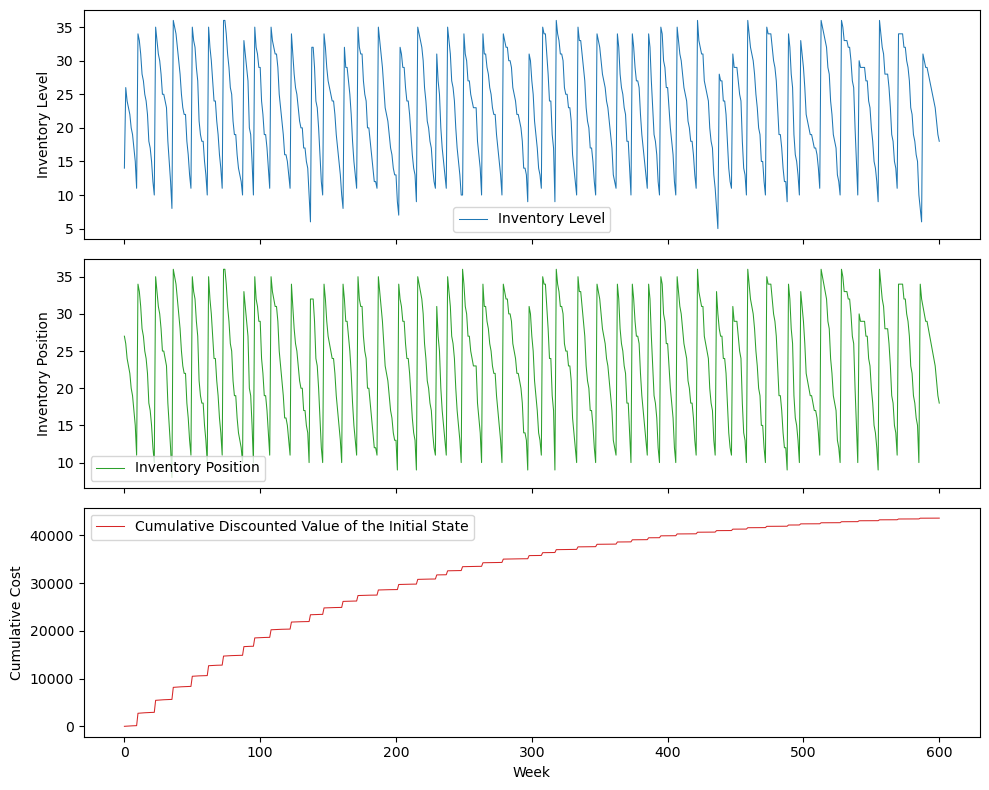

[0.00000000e+00 2.06960000e+01 3.97044800e+01 5.78298577e+01
 7.50804889e+01 9.06844690e+01 1.05434131e+02 1.18565212e+02
 1.30093528e+02 1.38505357e+02 2.73237290e+03 2.75735667e+03
 2.78070891e+03 2.80169580e+03 2.82183197e+03 2.84038335e+03
 2.85810363e+03 2.87426600e+03 2.88742364e+03 2.89978816e+03
 2.91064349e+03 2.91928433e+03 2.92644902e+03 5.44650543e+03
 5.46991308e+03 5.49179215e+03 5.51285957e+03 5.53242418e+03
 5.54980524e+03 5.56709939e+03 5.58361877e+03 5.59937068e+03
 5.61163663e+03 5.62180714e+03 5.62990287e+03 5.63527304e+03
 8.16399746e+03 8.18725759e+03 8.20974016e+03 8.23079442e+03
 8.25043411e+03 8.26867283e+03 8.28487597e+03 8.29970834e+03
 8.31382487e+03 8.32787083e+03 8.33930551e+03 8.34941886e+03
 8.35759486e+03 8.36447843e+03 1.04877151e+04 1.05081598e+04
 1.05278859e+04 1.05456732e+04 1.05621510e+04 1.05749031e+04
 1.05863829e+04 1.05972042e+04 1.06079713e+04 1.06168991e+04
 1.06245978e+04 1.06304903e+04 1.27030660e+04 1.27217339e+04
 1.27391475e+04 1.275474

In [8]:
# set the seed for reproducibility
np.random.seed(123)

# choose a random initial state from the state space
sampled_state = state_tuples[np.random.randint(len(state_tuples))]
print("Initial state:", sampled_state)

# simulate the period
data1 = simulate_period(sampled_state, policy)
print(total_cost(data1))

data1b = simulate_period(sampled_state, policy)
print(total_cost(data1, plots=False) - total_cost(data1b, plots=False))


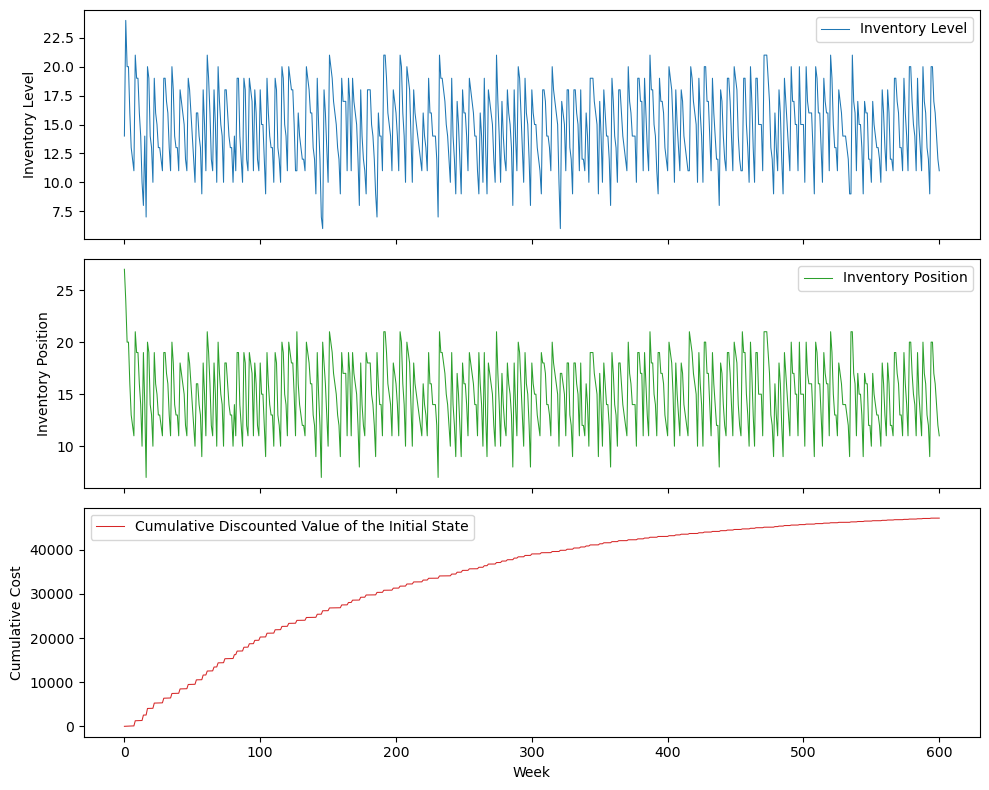

[0.00000000e+00 1.91040000e+01 3.49444000e+01 5.07055980e+01
 6.32515116e+01 7.33940986e+01 8.27096747e+01 9.12062564e+01
 1.26017755e+03 1.27470707e+03 1.28916395e+03 1.30127729e+03
 1.31182346e+03 1.31931878e+03 2.54538783e+03 2.55577660e+03
 2.56094502e+03 4.04494443e+03 4.05883305e+03 4.06901560e+03
 4.07842355e+03 4.08562425e+03 5.26350026e+03 5.27490645e+03
 5.28554630e+03 5.29472139e+03 5.30385060e+03 5.31223544e+03
 5.31988310e+03 6.37067594e+03 6.38375378e+03 6.39539649e+03
 6.40629956e+03 6.41511400e+03 6.42253509e+03 7.44286684e+03
 7.45488930e+03 7.46419335e+03 7.47278963e+03 7.48134292e+03
 7.48854414e+03 8.47734326e+03 8.48836140e+03 8.49867956e+03
 8.50830447e+03 8.51596590e+03 8.52295377e+03 9.48308933e+03
 9.49440995e+03 9.50442242e+03 9.51313952e+03 9.52057396e+03
 9.52673835e+03 1.05332570e+04 1.05430217e+04 1.05515230e+04
 1.05593777e+04 1.05647883e+04 1.16223627e+04 1.16312905e+04
 1.16378048e+04 1.25340506e+04 1.25451903e+04 1.25545242e+04
 1.25614896e+04 1.256784

In [9]:
from policy_df_genetor import *

# simulate with the policy given as optimal for flat shortage cost
policy2 = generate_sS_policy(11, 21, maximum_parts)
data2 = simulate_period(sampled_state, policy2)
print(total_cost(data2))

[ -286.76663901  -572.95345704   388.71032315  -752.20850434
  -286.13863756   400.63797607  -268.12051991 -1464.11199262
  -530.31644032   327.26914974  -706.14025427  -607.46554644
  -803.06785708  -451.30052467  -302.03847124    69.63509278
  -471.29797411  -318.90322117  -266.60286196  -391.58226019
  -355.46173891  -515.75888995  -717.12395552 -1039.67310714
  -227.15112976   -10.45626991     7.23885934   -89.65619921
  -478.09282084 -1108.54355308  -153.40285026  -520.29374148
  -424.96616608   196.46307133  -279.07242745  -725.93957536
   -56.85212179  -236.38577332   755.5731104   -500.40794364
   149.10946489  -510.5720918   -776.55970402 -1748.05898468
    -9.24361437   370.8340133   -221.71286689   238.24480297
  -763.02186131   501.5060744    194.50593385 -1044.92966941
   168.47418273  -558.98785899    89.55112571 -1202.56307277
   237.85057562  -368.17003199  -280.70609963 -1399.5478575
  -336.51220927  -650.08237718  -163.67892942    63.05306362
 -1174.47268057  -263.311

Text(0, 0.5, 'Residual')

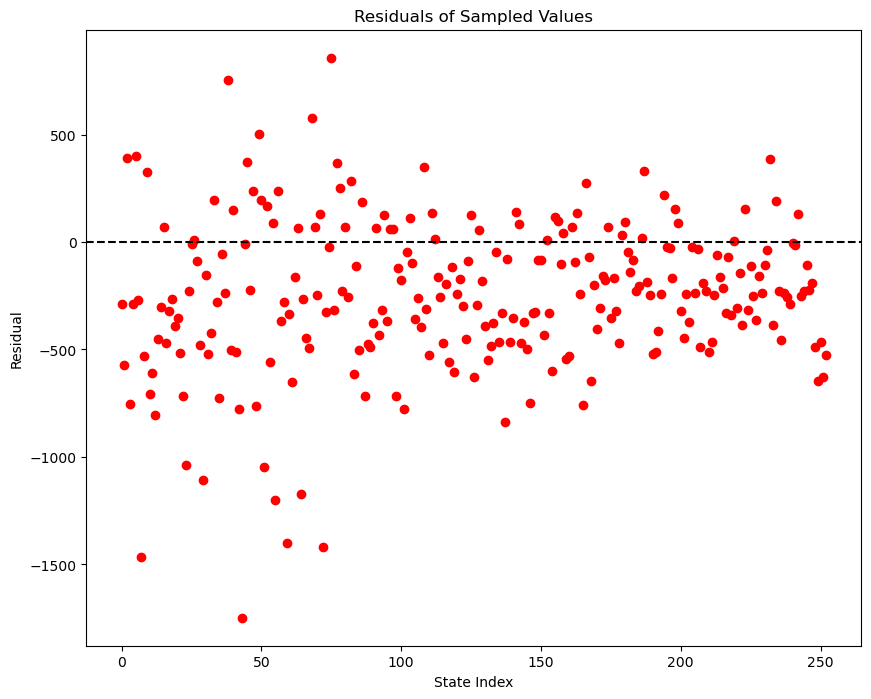

In [24]:
sample_size = 200
sampled_values = np.zeros(len(state_tuples))

for i, state in enumerate(state_tuples):
    value_samples = np.zeros(sample_size)
    for j in range(sample_size):
        sampled_data = simulate_period(state, policy, 4000)
        value_sample = total_cost(sampled_data, plots=False)
        value_samples[j] = value_sample
    sampled_values[i] = np.mean(value_samples)

value_iteration_values = np.load("values.npy")
residuals = sampled_values - value_iteration_values
print(residuals)

plt.figure(figsize=(10, 8))
plt.scatter(np.arange(253), residuals, color='red')
plt.axhline(0, color='black', linestyle='--')
plt.title("Residuals of Sampled Values")
plt.xlabel("State Index")
plt.ylabel("Residual")

The mean of the sampled costs: 49965.05298725046
Value obtained from value iteration 50297.29822643169
The difference between the two as a percentage of the value iteration value: -0.6605627954119966 %


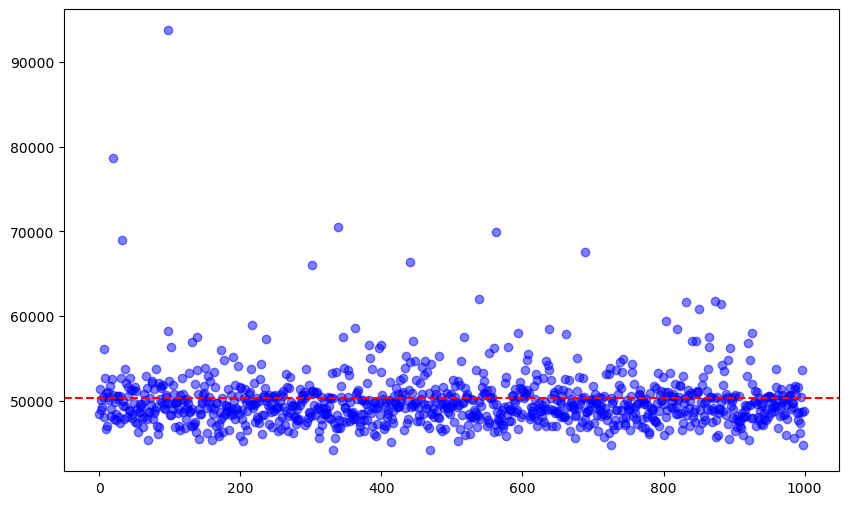

In [50]:
state = (7, 11)
state_idx = get_index(state[0], state[1], maximum_parts)
sampled_costs = np.zeros(1000)

for i in range(1000):
    sampled_data = simulate_period(state, policy, 5000)
    value_sample = total_cost(sampled_data, plots=False)
    sampled_costs[i] = value_sample

plt.figure(figsize=(10, 6))
plt.scatter(np.arange(1000), sampled_costs, color='blue', alpha=0.5)
plt.axhline(value_iteration_values[state_idx], color='red', linestyle='--', label='Value Iteration Value')

print("The mean of the sampled costs:", np.mean(sampled_costs))
print("Value obtained from value iteration", value_iteration_values[state_idx])
print("The difference between the two as a percentage of the value iteration value:",
      (np.mean(sampled_costs) - value_iteration_values[state_idx]) / value_iteration_values[state_idx] * 100, "%")

    